# Kickstarter data analysis by Cady Patino

**Questions:**
1. Which categories have the best and worst success rates?
2. How does success rate relate to goal amount?
3. Does duration of a project influence success rate?
4. What features have the greatest influence on success?
5. Can we predict success of current/future projects?
    

## First, A Look at the Data

In [1]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
# load in csv file as dataframe
df = pd.read_csv('ks-projects-201801.csv')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
df.shape

(378661, 15)

This data frame has 15 columns and 378,661 entries.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


It looks like from the kaggle description that 'usd pledged' and usd_pledged_real are both conversions of the pledged amount to usd, but done by different users. 'usd pledged' was calculated via Kickstarter and 'usd_pledged_real' was calculated via the Kaggle user tonyplaysguitar using the Fixer.io API. Let's take a look at some of the rows to see if they match up.

In [5]:
df[['country','pledged', 'usd pledged','usd_pledged_real']].head(15)

,country,pledged,usd pledged,usd_pledged_real
0,GB,0.00,0.00,0.00
1,US,2421.00,100.00,2421.00
2,US,220.00,220.00,220.00
3,US,1.00,1.00,1.00
4,US,1283.00,1283.00,1283.00
5,US,52375.00,52375.00,52375.00
6,US,1205.00,1205.00,1205.00
7,US,453.00,453.00,453.00
8,US,8233.00,8233.00,8233.00
9,US,6240.57,6240.57,6240.57


Above, I can already see that 'usd pledged' done by Kaggle has some mistakes, so I'll drop it and go with 'usd_pledged_real'. In addition, I'll drop the 'pledged' and 'goal' columns since these are represented consistently as USD in other columns.

In [6]:
# drop unnecessary columns
df.drop(['usd pledged', 'pledged','goal'], axis=1, inplace=True)

# confirm (should be 12)
df.shape[1]

12

I can also drop the ID and name columns since those will not be important in the analysis.

In [7]:
# drop ID column
df.drop(['ID','name'], axis=1, inplace=True)

# confirm (should be 11)
df.shape[1]

10

In [8]:
df.isnull().sum()

category            0
main_category       0
currency            0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

There are no null values in the dataset.

Let's take a look at some descriptive statistics for the numerical variables.

In [9]:
df.describe()

,backers,usd_pledged_real,usd_goal_real
count,378661.000000,3.786610e+05,3.786610e+05
mean,105.617476,9.058924e+03,4.545440e+04
std,907.185035,9.097334e+04,1.152950e+06
min,0.000000,0.000000e+00,1.000000e-02
25%,2.000000,3.100000e+01,2.000000e+03
50%,12.000000,6.243300e+02,5.500000e+03
75%,56.000000,4.050000e+03,1.550000e+04
max,219382.000000,2.033899e+07,1.663614e+08


We can see that there are a lot of high outliers in the three numerical features above, based on the fact that their max values are much greater than the lower 75% of the data.

Now let's take a closer look at the categorical variables.

In [10]:
df.category.value_counts()

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [11]:
df.category.nunique()

159

In [12]:
df.main_category.value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

In [13]:
df.main_category.nunique()

15

There are 15 main categories and 159 sub categories for these kickstarter projects. I now want to take a look at the proportion of projects in each main category.

In [14]:
# convert value count to df
df_main_cat_counts = df.main_category.value_counts().reset_index()
df_main_cat_counts.columns = ['main_category','count']
df_main_cat_counts

,main_category,count
0,Film & Video,63585
1,Music,51918
2,Publishing,39874
3,Games,35231
4,Technology,32569
5,Design,30070
6,Art,28153
7,Food,24602
8,Fashion,22816
9,Theater,10913


In [15]:
# set grid style
sns.set_style('darkgrid')

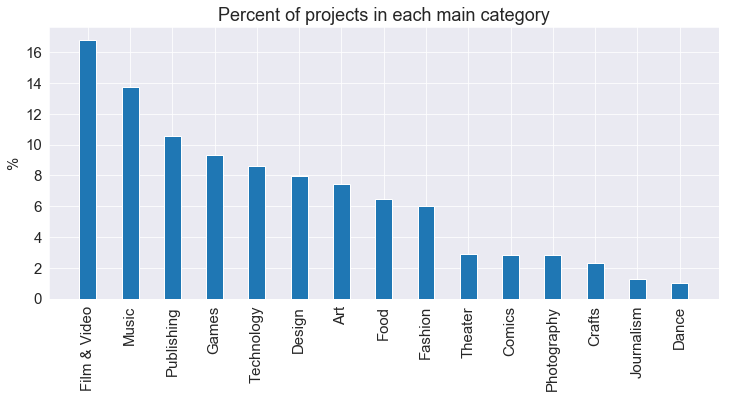

In [16]:
# plot percent of projects in each main category
heights = df_main_cat_counts['count']/len(df) *100
ind = np.arange(0,15)
labels = df_main_cat_counts['main_category'].values.tolist()

ind = np.arange(1,16)
width=0.4

plt.figure(figsize=(12,5))
plt.bar(ind, heights, width)
plt.xticks(ind, labels, rotation='vertical', size=15)
plt.yticks(size=15)
plt.ylabel('%', size=15)
plt.title('Percent of projects in each main category', size=18)

# save image
plt.savefig('category_percents.png', bbox_inches='tight')

We can see that Film & Video and Music were the most common main categories, while Dance and Journalism were the least common

Let's take a look now at the state of the projects to evaluate how many were successful and how many failed.

In [17]:
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [18]:
# disregard live, suspended, undefined, and canceled ones for now
df_completed = df[(df.state == 'successful') | (df.state == 'failed')]

perc_success = len(df_completed[df_completed.state == 'successful']) / len(df_completed) *100
perc_fail = 100 - perc_success

print('{:.2f}% of completed projects were successful.'.format(perc_success))
print('{:.2f}% of completed projects failed.'.format(perc_fail))

40.39% of completed projects were successful.
59.61% of completed projects failed.


Let's take a quick look at how the rest of the data breaks down by project state. I'll look at the median values since there seem to be a lot of outliers based on the descriptive statistics above.

In [19]:
df_by_state = df.groupby('state').median()

df_by_state.head()

,backers,usd_pledged_real,usd_goal_real
state,,,
canceled,3,87.00,10000.00
failed,3,100.00,7500.00
live,5,259.16,6547.09
successful,71,5107.25,3837.74
suspended,2,37.00,5000.00


Specifically paying attention to failed vs. successful, we can already see at first glance that the successful projects had a higher median for number of backers and pledged amount and a lower median for goal amount than the failed projects.

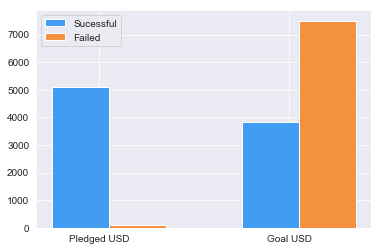

In [20]:
# plot pledged and goal medians for failed vs. successful projects
succ_heights = df_by_state.loc['successful'][['usd_pledged_real','usd_goal_real']].values.tolist()
fail_heights = df_by_state.loc['failed'][['usd_pledged_real','usd_goal_real']].values.tolist()

ind = np.arange(0,2)
labels = ['Pledged USD','Goal USD']

width = 0.3

plt.bar(ind, succ_heights, width, color='#419df4', label='Sucessful')
plt.bar(ind+width, fail_heights, width, color='#f49242', label='Failed')
plt.xticks(ind+0.1, labels)
plt.legend();

Now I'll take a closer look at the country variable.

In [21]:
df_completed.country.value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

The 'N,0"' value for country has 210 occurences. After googling what this means, I found that it most likely represents 'Null Island', a fictional island. Therefore, these values should be converted to null. First let me take a look at these entries.

In [22]:
df_completed[df_completed.country == 'N,0"'].head()

,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
2457,Music,Music,USD,2016-05-26,2016-04-26 19:46:26,successful,0,"N,0""",5170.00,5000.0
4892,Music,Music,USD,2016-05-11,2016-04-11 19:29:17,successful,0,"N,0""",5296.00,5000.0
5353,Music,Music,USD,2016-05-21,2016-04-21 16:14:28,successful,0,"N,0""",5077.00,3800.0
5597,Music,Music,USD,2016-05-08,2016-04-04 23:32:00,successful,0,"N,0""",3502.13,3500.0
8260,Music,Music,USD,2016-05-01,2016-03-25 17:20:21,successful,0,"N,0""",3787.00,3500.0


It looks like we can use the currency values to fill in the missing country names.

In [23]:
# get name of all distinct currencies in the null country entries
null_currencies = df_completed[df_completed.country == 'N,0"']['currency'].unique().tolist()
null_currencies

['USD', 'GBP', 'CAD', 'EUR', 'NOK', 'DKK', 'SEK', 'AUD']

Based on the list above, I can use most of the currencies to fill in the missing country data. Unfortunately, I cannot do this for the entries with euro listed as their currency, since euro is the currency for multiple countries.

In [24]:
# fill missing country values using currency (except for when currency is euro)
df_completed.country = np.where((df_completed.country == 'N,0"') & (df_completed.currency != 'EUR'), 
                                df_completed.currency.str[:-1], df_completed.country)
# convert remaining values of N,0" to null
df_completed.country = np.where(df_completed.country == 'N,0"', None, df_completed.country)

/Users/cadpav/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [25]:
df_completed.country.value_counts(dropna=False)

US     261511
GB      29476
CA      12375
AU       6621
DE       3436
FR       2520
NL       2411
IT       2369
ES       1873
SE       1510
MX       1411
NZ       1274
DK        929
IE        683
CH        652
NO        584
BE        523
AT        485
HK        477
SG        454
LU         57
JP         23
NaN        21
Name: country, dtype: int64

There are still 21 missing values for country since the missing entries with euro as their currency could not be determined. Luckily this is a very small percent of the total entries, so I will go ahead and drop these rows.

In [26]:
df_completed = df_completed[df_completed.country.notnull()]

In [27]:
# confirm
df_completed.country.isnull().sum()

0

Next I want to use the deadline and launched columns to create a duration column.

In [28]:
# convert deadline and launched columns from strings to datetime objects
df_completed.deadline = pd.to_datetime(df_completed.deadline)
df_completed.launched = pd.to_datetime(df_completed.launched).dt.date #drops time part
df_completed.launched = pd.to_datetime(df_completed.launched) #convert back to datetime object
    
# create duration column
df_completed['duration'] = df_completed.deadline - df_completed.launched #creates timedelta object
# convert from timedelta to number of days
df_completed['duration'] = df_completed['duration'].apply(lambda x: x.days)

In [29]:
# confirm
df_completed.duration.head()

0    59
1    60
2    45
3    30
5    35
Name: duration, dtype: int64

Finally I want to map the values in the state column to 1 for successful and 0 for failed.

In [30]:
# map successful to 1, failed to 0
df_completed.state = df_completed.state.map({'successful':1, 'failed':0})

# rename column
df_completed.rename({'state':'succeeded'}, axis=1, inplace=True)

In [31]:
df_completed.head()

,category,main_category,currency,deadline,launched,succeeded,backers,country,usd_pledged_real,usd_goal_real,duration
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11,0,0,GB,0.0,1533.95,59
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,0,15,US,2421.0,30000.00,60
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12,0,3,US,220.0,45000.00,45
3,Music,Music,USD,2012-04-16,2012-03-17,0,1,US,1.0,5000.00,30
5,Restaurants,Food,USD,2016-04-01,2016-02-26,1,224,US,52375.0,50000.00,35


### Explore Question 1: Which categories have the best and worst success rates?

Now I'll take a look at how successes and failures break down by category.

In [32]:
def plot_success_rate(df, col, xlabel=''):
    """
    Creates a table and plot of the success and failure rates grouped by 
    the specified column in the dataframe.
    
    INPUTS: dataframe, column to group by
    OUTPUTS: table of success rates and failure rates, sorted by success rate, plot of success rates
    """
    succ_rate = df.groupby(col).mean()['succeeded'] *100
    fail_rate = 100 - succ_rate
    
    results = pd.concat([succ_rate, fail_rate], axis=1)
    results.columns = ['success_rate', 'failed_rate']
    
    results = results.sort_values(by='success_rate', ascending=False)
    
    # plot success rate
    heights = results.success_rate.values.tolist()

    ind = np.arange(0,len(results))
    labels = results.index.values.tolist()

    width = 0.4

    plt.figure(figsize=(12,5))
    plt.bar(ind, heights, width)
    plt.xticks(ind, labels, rotation=45, size=15)
    plt.yticks(size=15)
    plt.ylabel('% of successful projects', size=15)
    plt.xlabel(xlabel, size=15)
    
    title = 'Success rate broken down by {}'.format(col)
    plt.title(title, size=18);

    return results

               success_rate  failed_rate
main_category                           
Dance             65.435209    34.564791
Theater           63.796134    36.203866
Comics            59.141527    40.858473
Music             52.665491    47.334509
Art               44.889045    55.110955
Games             43.890467    56.109533
Film & Video      41.792127    58.207873
Design            41.592083    58.407917
Publishing        34.707526    65.292474
Photography       34.110847    65.889153
Fashion           28.284616    71.715384
Food              27.591367    72.408633
Crafts            27.052955    72.947045
Journalism        24.397300    75.602700
Technology        23.785582    76.214418


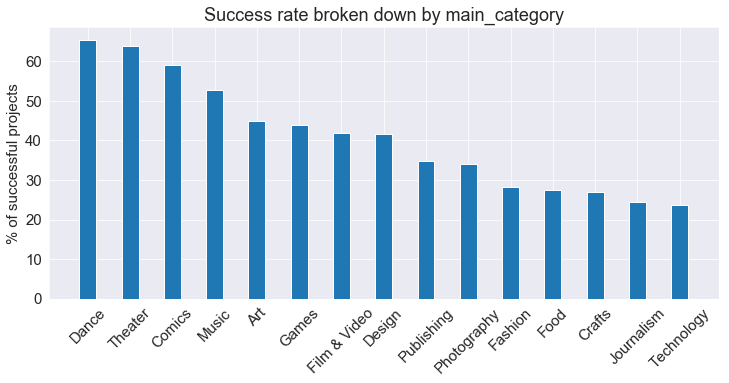

In [33]:
results = plot_success_rate(df_completed, 'main_category')
plt.savefig('category_success.png', bbox_inches='tight')

print(results)

The four categories that had the highest proportion of successful projects (greater than 50%) were Dance, Theater, Comics, and Music. All other categories had a higher percentage of failed projects than successful projects (i.e. less than a 50% success rate). Technology had the lowest proportion of successful projects, at about 24%.

But what if categories with the lowest success rate end to have higher goal amounts and THAT is what affects the outcome more? Let's look at this by plotting the median goal amount for each category (I want to look at median instead of mean since there are a lot of high outliers for goal amount).

In [34]:
# create df of success rate for each category
succ_rate = df_completed.groupby('main_category').mean()['succeeded'] *100
succ_rate = succ_rate.reset_index().sort_values(by='succeeded', ascending=False)

In [35]:
# get list of categories in order
categories_ordered = succ_rate.main_category.values.tolist()
categories_ordered

['Dance',
 'Theater',
 'Comics',
 'Music',
 'Art',
 'Games',
 'Film & Video',
 'Design',
 'Publishing',
 'Photography',
 'Fashion',
 'Food',
 'Crafts',
 'Journalism',
 'Technology']

In [36]:
# create df of median values grouped by category
median_by_cat = df_completed.groupby('main_category').median()
median_by_cat

,succeeded,backers,usd_pledged_real,usd_goal_real,duration
main_category,,,,,
Art,0,12,537.000,2966.70,30
Comics,1,46,1735.000,3500.00,30
Crafts,0,4,109.630,2176.06,30
Dance,1,29,2040.000,3200.00,30
Design,0,34,2279.000,10000.00,30
Fashion,0,6,293.945,5500.00,30
Film & Video,0,15,963.680,6400.00,30
Food,0,7,323.000,10000.00,30
Games,0,40,1743.000,7500.00,30


In [37]:
# reorder the categories to the be same as success rate df
median_by_cat = median_by_cat.reindex_axis(categories_ordered, axis=0)
median_by_cat

/Users/cadpav/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  from ipykernel import kernelapp as app


,succeeded,backers,usd_pledged_real,usd_goal_real,duration
main_category,,,,,
Dance,1,29,2040.000,3200.00,30
Theater,1,27,1728.500,3101.35,30
Comics,1,46,1735.000,3500.00,30
Music,1,22,1199.100,4000.00,30
Art,0,12,537.000,2966.70,30
Games,0,40,1743.000,7500.00,30
Film & Video,0,15,963.680,6400.00,30
Design,0,34,2279.000,10000.00,30
Publishing,0,9,381.000,4995.07,30


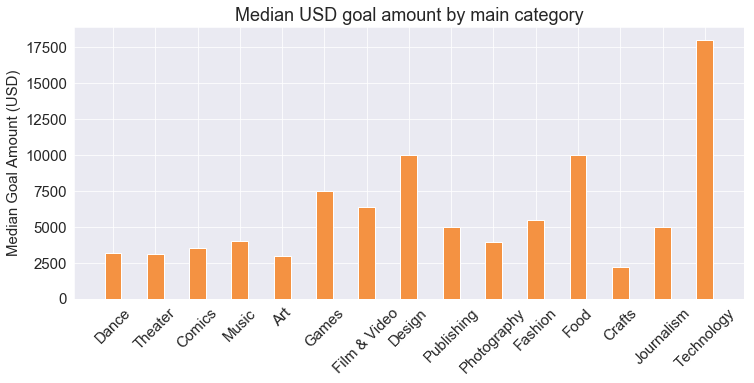

In [38]:
# plot median goal amount per category
heights = median_by_cat.usd_goal_real.values.tolist()

ind = np.arange(0,len(median_by_cat))
labels = median_by_cat.index.values.tolist()

width = 0.4

plt.figure(figsize=(12,5))
plt.bar(ind, heights, width, color = '#f49242')
plt.xticks(ind, labels, rotation=45, size=15)
plt.yticks(size=15)
plt.ylabel('Median Goal Amount (USD)', size=15)
    
plt.title('Median USD goal amount by main category', size=18);
plt.savefig('category_goal.png', bbox_inches='tight')


This looks like it could be the case for Technology, which does have the highest median goal amount seen in the graph above to the right (with the categories plotted in the same order as the graph on the left). However, this is not always the case - for example, Crafts has the lowest median goal amount but still has one of the lowest success rates.

### Explore Question 2: How does success rate relate to goal amount?

First I'll look at the median goal amounts for the successful and failed projects, and also plot goal against 'succeeded' on a category plot.

In [39]:
# group by succeeded and get median of goal
median_goal = df_completed.groupby('succeeded').median()['usd_goal_real'].reset_index()
median_goal.columns = ['succeeeded','median_goal_USD']
median_goal

,succeeeded,median_goal_USD
0,0,7500.00
1,1,3836.92


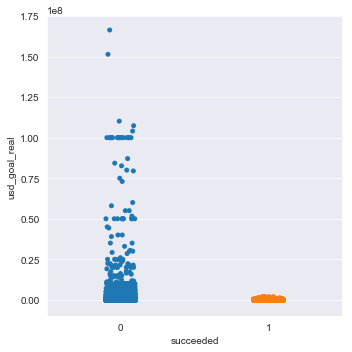

In [40]:
# create category plot
sns.catplot(x="succeeded", y="usd_goal_real", data=df_completed);

As found earlier, the median goal amount for the failed projects is almost twice as high as that of the successful projects. We can also see from the plot that the goal spread for the failed projects is much wider.

Now I want to create a new column to bucket the goals into ranges. First I'll look again at the descriptive statistics for usd_goal_real so that I can choose appropriate bin values.

In [41]:
df_completed.usd_goal_real.describe()

count    3.316540e+05
mean     4.151218e+04
std      1.108965e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

In [42]:
# specify bin values
bin_values = [0,5000,10000,15000,20000,25000,50000, df_completed.usd_goal_real.max()]

# cut goal amount into buckets based on bin values
df_completed['usd_goal_bucket'] = pd.cut(df_completed.usd_goal_real, bin_values)

In [43]:
# get value counts for goal bucket column
df_completed.usd_goal_bucket.value_counts()

(0.0, 5000.0]              167910
(5000.0, 10000.0]           59217
(25000.0, 50000.0]          26779
(10000.0, 15000.0]          25130
(50000.0, 166361390.71]     22932
(15000.0, 20000.0]          17618
(20000.0, 25000.0]          12068
Name: usd_goal_bucket, dtype: int64

From these counts, we can see that the majority of the goal amounts are in the 0 to $5000 range. Now I can see how the success rate breaks down by these goal buckets.

                         success_rate  failed_rate
usd_goal_bucket                                   
(0.0, 5000.0]               48.983384    51.016616
(5000.0, 10000.0]           39.468396    60.531604
(10000.0, 15000.0]          37.405491    62.594509
(15000.0, 20000.0]          32.546260    67.453740
(20000.0, 25000.0]          28.588001    71.411999
(25000.0, 50000.0]          25.202584    74.797416
(50000.0, 166361390.71]     13.077795    86.922205


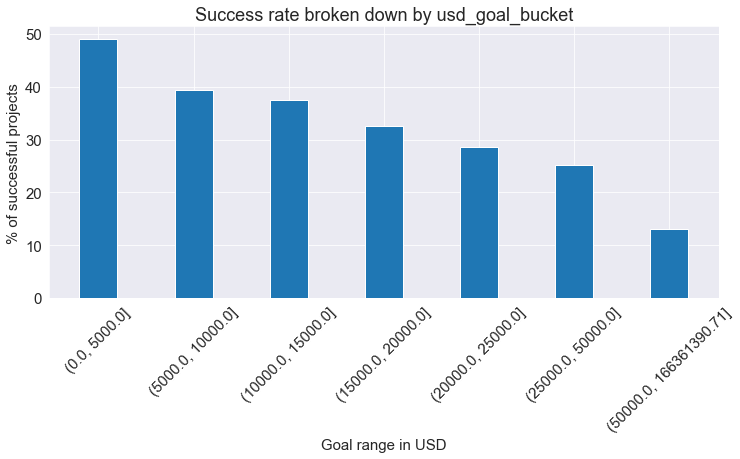

In [44]:
results = plot_success_rate(df_completed, 'usd_goal_bucket', xlabel='Goal range in USD')
plt.savefig('goal_success.png', bbox_inches='tight')

print(results)

From the plot above, we can see that with increasing goal buckets, the proportion of successful projects decreases. The lowest bucket (0 to $5000) has almost a 50% success rate, while the highest bucket has only a 13% success rate.

### Explore Question 3: Does duration of a project influence success rate?

In [45]:
# group by succeeded and get average duration
average_goal = df_completed.groupby('succeeded').mean()['duration'].reset_index()
average_goal.columns = ['succeeeded','avg_duration']
average_goal

,succeeeded,avg_duration
0,0,35.173433
1,1,32.156496


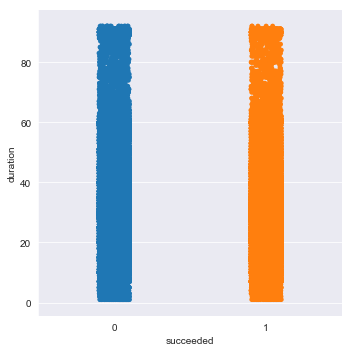

In [46]:
# create category plot
sns.catplot(x="succeeded", y="duration", data=df_completed);

The average durations for the failed and succeeded projects are similar, only about 3 days off from each other. From the plot above we can see that the data seems to be more uniform across duration lengths for both the failed and successful projects.

In [47]:
# get number of unique duration lengths
df_completed.duration.nunique()

92

In [48]:
# get value counts
df_completed.duration.value_counts()

30    148468
60     27969
45     15240
31     11718
35      8620
40      8594
32      6465
21      6124
20      6060
29      5540
25      5518
33      5070
15      4860
28      4848
14      3848
34      3210
36      3016
27      2654
22      2461
26      2373
24      2304
37      2279
50      2193
10      2081
23      2062
38      1908
46      1806
42      1731
39      1682
7       1642
       ...  
3        194
2        129
63       124
66       107
88       105
65       105
70        98
1         92
64        83
71        82
75        81
76        75
72        74
67        69
68        61
87        61
80        59
86        59
69        57
85        56
81        49
78        49
73        49
83        47
84        47
82        46
77        45
74        43
79        35
92        22
Name: duration, Length: 92, dtype: int64

There are 92 unique durations in the dataset. Since some of these are very sparse, I will bucket these values.

In [49]:
df_completed.duration.describe()

count    331654.000000
mean         33.954920
std          12.713587
min           1.000000
25%          30.000000
50%          30.000000
75%          36.000000
max          92.000000
Name: duration, dtype: float64

In [50]:
# specifiy bin values
bin_values = [0,14,20,25,30,40,50,df_completed.duration.max()]

# cut duration into buckets based on bin values
df_completed['duration_bucket'] = pd.cut(df_completed.duration, bin_values)

In [51]:
# get value counts for duration bucket column
df_completed.duration_bucket.value_counts()

(25, 30]    163883
(30, 40]     52562
(50, 92]     39803
(40, 50]     27873
(20, 25]     18469
(14, 20]     16624
(0, 14]      12440
Name: duration_bucket, dtype: int64

Above we can see that the majority of projects fell in the 25-30 day range for duration. Now let's see how success rate breaks down for each duration bucket.

,success_rate,failed_rate
duration_bucket,,
"(20, 25]",56.245601,43.754399
"(0, 14]",52.106109,47.893891
"(14, 20]",50.210539,49.789461
"(30, 40]",50.119858,49.880142
"(40, 50]",38.338177,61.661823
"(25, 30]",37.363851,62.636149
"(50, 92]",26.309575,73.690425


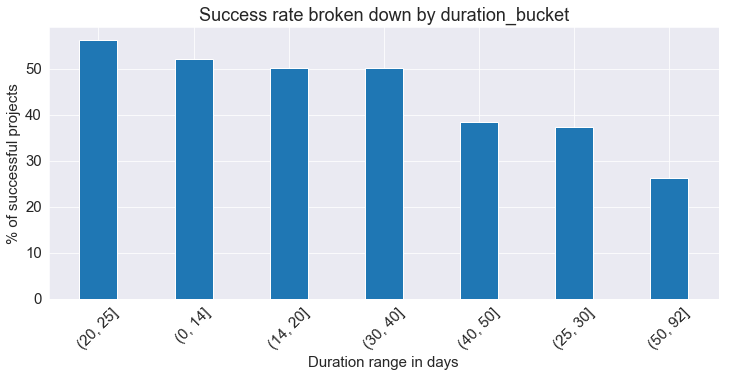

In [52]:
plot_success_rate(df_completed, 'duration_bucket', xlabel='Duration range in days')

From the plot above, we can see that projects that lasted 20-25 days had the greatest success rate (56%) and projects that lasted over 50 days had the lowest success rate (26%).

### For Questions 4 and 5, I need to use machine learning to build a logistic regression model. These will be explored in a separate jupyter notebook.